In [2]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00


In [3]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
yolo_model = YOLO("/content/best.pt")  # Path model YOLO v9c yang telah dilatih

In [6]:
dcnn_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Yolo.Png/model.h5")  # Path model DCNN


In [21]:
def detect_and_classify(image_path):
    """Gabungan YOLO v9c untuk deteksi dan DCNN untuk klasifikasi lebih lanjut"""
    print(f"📷 Memproses gambar: {image_path}")

    # Load gambar dengan OpenCV
    img_cv2 = cv2.imread(image_path)

    # 1️⃣ **Gunakan YOLO v9c untuk Deteksi dan Segmentasi**
    results = yolo_model(img_cv2)

    # Buat folder penyimpanan hasil segmentasi
    output_folder = "segmented_images"
    os.makedirs(output_folder, exist_ok=True)

    predictions = {}

    for i, result in enumerate(results):
        for j, box in enumerate(result.boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box koordinat
            class_id = int(box.cls[0])  # ID kelas yang terdeteksi
            confidence = box.conf[0].item()  # Confidence score

            # Ambil nama kelas berdasarkan indeks (sesuai dataset YOLO custom)
            labels = ["Penyakit Kuning", "Bercak Daun", "Keriting Daun"]
            predicted_class = labels[class_id]

            # Crop hasil deteksi untuk diklasifikasikan ulang oleh DCNN
            cropped_img = img_cv2[y1:y2, x1:x2]
            cropped_img_path = f"{output_folder}/segmented_{i}_{j}.jpg"
            cv2.imwrite(cropped_img_path, cropped_img)  # Simpan hasil segmentasi

            # 2️⃣ **Gunakan DCNN untuk Klasifikasi Penyakit (Validasi YOLO)**
            img_pil = image.load_img(cropped_img_path, target_size=(224, 224))
            img_array = image.img_to_array(img_pil)
            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

            dcnn_predictions = dcnn_model.predict(img_array)
            dcnn_labels = ["Penyakit Kuning", "Bercak Daun", "Keriting Daun"]
            refined_class = dcnn_labels[np.argmax(dcnn_predictions)]

            # Simpan hasil prediksi gabungan
            predictions[cropped_img_path] = {
                "YOLO_Prediction": predicted_class,
                "YOLO_Confidence": confidence,
                "DCNN_Refined_Prediction": refined_class,
                "BoundingBox": (x1, y1, x2, y2)
            }

    return predictions


In [22]:
import matplotlib.pyplot as plt

def display_results(image_path, output_results):
    """Menampilkan gambar dengan bounding box dari hasil YOLO v9c dan label klasifikasi DCNN"""

    # Load gambar asli
    img_cv2 = cv2.imread(image_path)

    # Konversi warna dari BGR ke RGB untuk ditampilkan dengan Matplotlib
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Gambar asli dengan bounding box
    for img_path, result in output_results.items():
        x1, y1, x2, y2 = result["BoundingBox"]
        yolo_label = result["YOLO_Prediction"]
        dcnn_label = result["DCNN_Refined_Prediction"]
        confidence = result["YOLO_Confidence"]

        # Gambar bounding box
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Tampilkan teks label dan confidence
        label_text = f"{yolo_label} ({confidence:.2f})\nDCNN: {dcnn_label}"
        cv2.putText(img_rgb, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Tampilkan gambar hasil deteksi
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Deteksi Penyakit Cabai dengan YOLO v9c + DCNN")
    plt.show()


📷 Memproses gambar: /content/tst1.jpg

0: 640x640 2 Daun Bercaks, 2001.9ms
Speed: 22.0ms preprocess, 2001.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
segmented_images/segmented_0_0.jpg:
  YOLO Prediksi: Penyakit Kuning (Confidence: 0.97)
  DCNN Refined: Penyakit Kuning
segmented_images/segmented_0_1.jpg:
  YOLO Prediksi: Penyakit Kuning (Confidence: 0.67)
  DCNN Refined: Penyakit Kuning


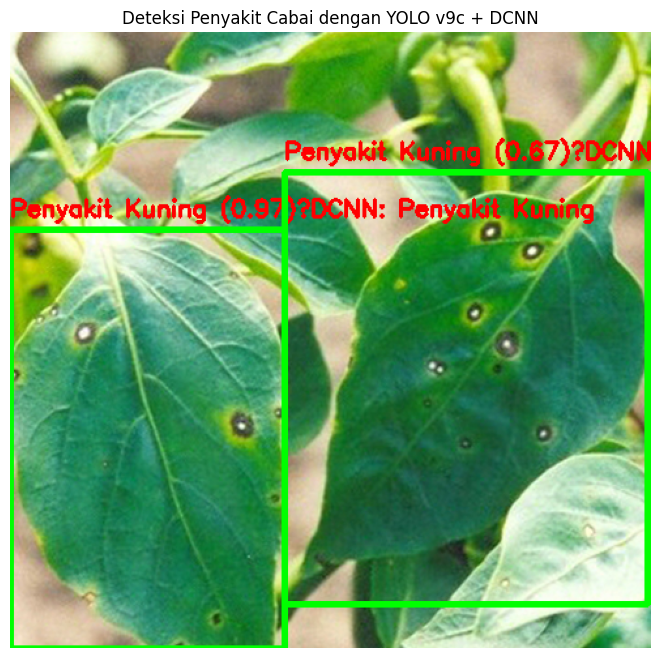

In [23]:
# Contoh gambar input
input_image = "/content/tst1.jpg"

# Jalankan model YOLO v9c + DCNN gabungan
output_results = detect_and_classify(input_image)

# Tampilkan hasil deteksi penyakit
for img, result in output_results.items():
    print(f"{img}:")
    print(f"  YOLO Prediksi: {result['YOLO_Prediction']} (Confidence: {result['YOLO_Confidence']:.2f})")
    print(f"  DCNN Refined: {result['DCNN_Refined_Prediction']}")

# Tampilkan gambar dengan bounding box
display_results(input_image, output_results)


📷 Memproses gambar: /content/IMG_0067(1).png

0: 640x640 1 Daun Bercak, 1681.6ms
Speed: 5.3ms preprocess, 1681.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
segmented_images/segmented_0_0.jpg:
  YOLO Prediksi: Penyakit Kuning (Confidence: 0.97)
  DCNN Refined: Penyakit Kuning


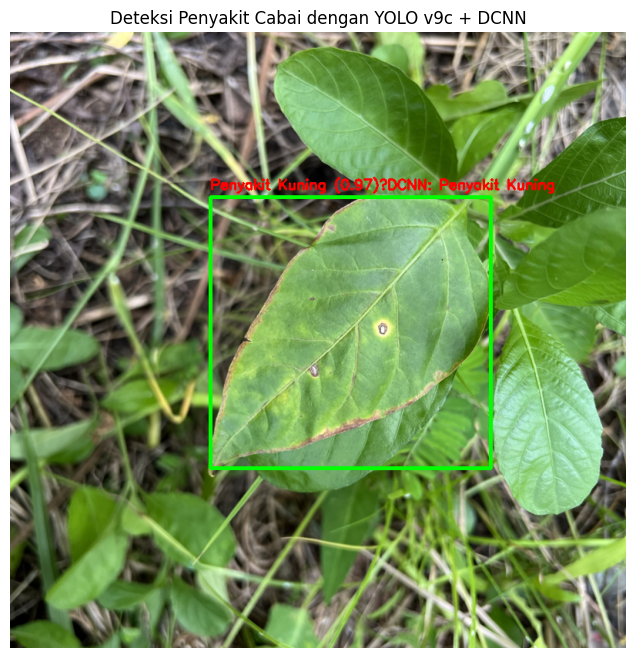

In [24]:
# Contoh gambar input
input_image = "/content/IMG_0067(1).png"

# Jalankan model YOLO v9c + DCNN gabungan
output_results = detect_and_classify(input_image)

# Tampilkan hasil deteksi penyakit
for img, result in output_results.items():
    print(f"{img}:")
    print(f"  YOLO Prediksi: {result['YOLO_Prediction']} (Confidence: {result['YOLO_Confidence']:.2f})")
    print(f"  DCNN Refined: {result['DCNN_Refined_Prediction']}")

# Tampilkan gambar dengan bounding box
display_results(input_image, output_results)
